In [1]:
"""Classes and methods for array-based spatial transcriptomics analysis."""

import itertools
from typing import Iterable, Iterator, Sequence, cast
from multiprocessing import Process, Queue
from warnings import simplefilter

import numpy as np
import numpy.typing as npt
from scipy import sparse
from countdata import CountTable
from classifier import Classifier
import densetools


def combine_coords(coords: Iterable[int]) -> str:
    """Combines a tuple of ints into a unique string identifier."""
    return ','.join(map(str, coords))


def split_coords(ident: str) -> tuple[int, ...]:
    """Splits a unique identifier into its corresponding coordinates.

    Args:
        ident: A string of the form '{x1},{x2},...,{xn}'.

    Returns:
        A tuple of integers (x1, x2, ..., xn).
    """
    return tuple(map(int, ident.split(','))) if ident else ()


def first_coord(ident: str) -> int:
    """Obtains the first coordinate from a unique identifier.

    Args:
        ident: A string of the form '{x1},{x2},...,{xn}' where n>=1.

    Returns:
        The integer x1.
    """
    return split_coords(ident)[0]


def second_coord(ident: str) -> int:
    """Obtains the first coordinate from a unique identifier.

    Args:
        ident: A string of the form '{x1},{x2},...,{xn}' where n >= 2.

    Returns:
        The integer x2.
    """
    return split_coords(ident)[1]


def cartesian_product(x: npt.ArrayLike, y: npt.ArrayLike) -> npt.NDArray:
    """Computes the cartesian products of two 1-d vectors.

    Args:
        x: The first vector
        y: The second vector

    Returns:
        An array of shape (len(x) * len(y), 2) whose rows are precisely all
        possible tuples with first value in x and second value in y.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    return np.transpose([np.tile(x, len(y)),
                         np.repeat(y, len(x))])


def square_nbhd(point: tuple[int, int],
                scale: int,
                x_range: tuple[int, int],
                y_range: tuple[int, int]
                ) -> Iterator[tuple[int, int]]:
    """All coordinates in a square neighbourhood about a point.

    Args:
        point: the (x,y) coordinates of the point
        scale: the radius of the square
        x_range: the least and greatest acceptable x values
        y_range: the least and greated acceptable y values

    Yields:
        All tuples (i,j) satisfying the following:
            - x_range[0] <= i <= x_range[1]
            - y_range[0] <= j <= y_range[1]
            - d(x,i) <= scale
            - d(y,j) <= scale
    """
    x, y = point
    x_min, x_max = x_range
    y_min, y_max = y_range
    x_min = max(x_min, x - scale)
    x_max = min(x_max, x + scale)
    y_min = max(y_min, y - scale)
    y_max = min(y_max, y + scale)
    return itertools.product(range(x_min, x_max+1), range(y_min, y_max+1))


def square_nbhd_vec(point: tuple[int, int],
                    scale: int,
                    x_range: tuple[int, int],
                    y_range: tuple[int, int]
                    ) -> npt.NDArray:
    """Returns a 2D array of all coords in a square nbhd about a point

    Args:
        point: the (x,y) coordinates of the point
        scale: the radius of the square
        x_range: the least and greatest acceptable x values
        y_range: the least and greated acceptable y values

    Returns:
        An array A of shape (n*m, 2) where n = x_range[1] - x_range[0] + 1
        and m = y_range[1] - y_range[0] + 1, whose rows are precisely the
        elements of square_nbhd(point, scale, x_range, y_range).
    """
    x, y = point
    x_min, x_max = x_range
    y_min, y_max = y_range
    if x_max < x_min or y_max < y_min:
        return np.empty((0,2))
    x_min = max(x_min, x - scale)
    x_max = min(x_max, x + scale)
    y_min = max(y_min, y - scale)
    y_max = min(y_max, y + scale)
    return cartesian_product(np.arange(x_min, x_max + 1),
                             np.arange(y_min, y_max + 1))


def extract_classifications(confidence_matrix: npt.NDArray,
                            threshold: float
                            ) -> dict[tuple[int, int], int]:
    """Extracts a dictionary of all spot classifications given the threshold.

    Args:
        confidence_matrix:
            A matrix X such that X[i, j, s, c] is the confidence that the
            cell type of spot (i, j) is c at scale s.
        threshold:
            The confidence threshold.

    Returns:
        A dictionary d such that (i, j) is in d if and only if there is some
        scale s and cell type c so that confidence_matrix[i, j, s, c] >= threshold.
        Moreover, d[x,y] is the value of c corresponding to the lowest such
        value of s.
    """
    confident = zip(*np.where(confidence_matrix >= threshold))
    confident = cast(Iterator[tuple[int, int, int, int]], confident)

    classifications: dict[tuple[int, int], int] = {}

    for i, j, _, cell_type in confident:
        if (i, j) not in classifications:
            classifications[i, j] = cell_type

    return classifications


def extract_image(confidence_matrix: npt.NDArray,
                  threshold: float
                  ) -> npt.NDArray:
    classifications = extract_classifications(confidence_matrix, threshold)

    image = np.empty(confidence_matrix.shape[:2])
    image[:] = np.nan

    for (i, j), c in classifications.items():
        image[i, j] = c

    return image




In [2]:
class ExpressionGrid:
    """A spatial grid equipped with gene expressions.

    An ExpressionGrid encapsulates a 2D grid. For each coordinate (x,y) in the
    grid, we have a corresponding gene expression vector where each entry
    counts the number of reads of its corresponding gene.

    Attributes:
        x_min: The smallest x coordinate in the grid.
        y_min: The smallest y coordinate in the grid.
        x_max: The largest x coordinate in the grid.
        y_max: The largest y coordinate in the grid.
        height: The height of the grid.
        width: The width of the grid.
    """
    def __init__(self,
                 table,
                 genes: Sequence[str],
                 gene_col: str = "gene",
                 count_col: str = "count"
                 ):
        """Inits grid with expression readingsfrom a dataframe.

        Args:
            table: A dataframe of spot-level gene counts.
                Each row in the dataframe corresponds to a reading of one
                gene at one spot.
                Columns:
                    x: The x coordinate of the reading.
                    y: The y coordinate of the reading.
                    {gene_col}: The gene detected by the reading.
                    {count_col}: The number of transcripts measured.
            genes:
                A full list of all genes under consideration, in order. This
                should match the list of genes used for other CountData
                intended to be compared with this sample.
            gene_col:
                A string labelling the column containing gene names.
            count_col:
                A string labelling the column containing transcript counts.
        """
        self.x_min, self.x_max = table.x.min(), table.x.max()
        self.y_min, self.y_max = table.y.min(), table.y.max()
        self.height: int = self.x_max - self.x_min + 1
        self.width: int = self.y_max - self.y_min + 1
        num_genes = len(genes)
        matrix = sparse.lil_matrix(((self.height) * (self.width),
                                   num_genes)
                                   )
        for row in table.itertuples():
            matrix[self._flatten_coords(row.x, row.y),
                   genes.index(getattr(row, gene_col))
                   ] = getattr(row, count_col)
        self.matrix = matrix.tocsc()
        self.num_genes = cast(int, num_genes)

    def rows(self) -> range:
        """Returns a range of all row indices in the grid."""
        return range(self.x_min, self.x_max+1)

    def cols(self) -> range:
        """Returns a range of all column indices in the grid."""
        return range(self.y_min, self.y_max+1)

    def _flatten_coords(self, i: int, j: int) -> int:
        return self.width * (i - self.x_min) + (j - self.y_min)

    def _flatten_coords_vec(self, coords) -> npt.ArrayLike:
        return ((self.width, 1) * (coords - (self.x_min, self.y_min))).sum(axis=1)

    def expression(self, *coords: tuple[(int, int)]) -> sparse.spmatrix:
        """The total expression at these coordinates in the grid"""
        return self.matrix[list(map(lambda p: self._flatten_coords(*p),
                                    coords
                                    ))].sum(axis=0)

    def expression_vec(self, coords: npt.NDArray) -> sparse.spmatrix:
        flattened = self._flatten_coords_vec(coords)
        return self.matrix[flattened].sum(axis=0)

    def square_nbhd(self,
                    i: int,
                    j: int,
                    scale: int
                    ) -> Iterator[tuple[int, int]]:
        """All coordinates (x,y) in the grid such that d(x,i), d(y-j) <= scale"""
        return square_nbhd((i, j), scale, (self.x_min, self.x_max),
                           (self.y_min, self.y_max))

    def square_nbhd_vec(self, i: int, j: int, scale: int) -> npt.NDArray:
        return square_nbhd_vec((i, j), scale, (self.x_min, self.x_max),
                               (self.y_min, self.y_max))


In [3]:


# class Worker(Process):

#     def __init__(self,
#                  grid: ExpressionGrid,
#                  min_scale: int,
#                  max_scale: int,
#                  classifier: Classifier,
#                  job_queue: Queue,
#                  res_queue: Queue,
#                  procid: int,
#                  verbose: bool
#                  ):
#         super().__init__()
#         self.grid = grid
#         self.min_scale = min_scale
#         self.max_scale = max_scale
#         self.classifier = classifier
#         self.job_queue = job_queue
#         self.res_queue = res_queue
#         self.procid = procid
#         self.verbose = verbose

#     def run(self):
#         simplefilter(action='ignore', category=FutureWarning)
#         if self.verbose:
#             print(f'Worker {self.procid} started')

#         num_classes = len(self.classifier.classes)

#         cols = list(self.grid.cols())
#         num_scales = self.max_scale - self.min_scale + 1
#         exprs = np.zeros((num_scales, self.grid.num_genes))
#         a =0
#         print('1',len(self.job_queue))
#         for i, col_values in iter(self.job_queue.get, None):
#             a+=1
#             if self.verbose:
#                 print(f"Worker {self.procid} got job {i}")
#             for col_index in col_values:
#                 j = cols[col_index]
#                 for scale in range(self.min_scale, self.max_scale + 1):
#                     nbhd = self.grid.square_nbhd_vec(i, j, scale)
#                     expr = self.grid.expression_vec(nbhd)
#                     exprs[scale - self.min_scale] = expr

#                 first_nonzero = densetools.first_nonzero_1d(exprs.sum(axis=1))

#                 probs = np.empty((num_scales, num_classes))
#                 probs[:] = -1

#                 if 0 <= first_nonzero < num_scales:
#                     to_classify = np.vstack(exprs[first_nonzero:])  # pyright: ignore # noqa: E501

#                     all_confidences = self.classifier.classify(to_classify)

#                     probs[first_nonzero:] = all_confidences

#                     # sample_confidences = np.max(all_confidences, axis=1)

#                     # first_confident = utf1st.find_1st(sample_confidences,
#                     #                                   self.threshold,
#                     #                                   utf1st.cmp_larger_eq)

#                     # if 0 <= first_confident < num_scales - first_nonzero:
#                     #     sample_probs = all_confidences[first_confident]
#                     #     index = np.argmax(sample_probs)
#                     #     result = classifier.classes[index]
#                     #     scale = first_confident + first_nonzero + self.min_scale
#                     # else:
#                     #     result = scale = None
#                     # self.res_queue.put((i, j, result, scale))
#                 self.res_queue.put((i, j, probs.tolist()))
#                 print()
#         self.res_queue.put(None)
#         if self.verbose:
#             print(f'Worker {self.procid} finished')



In [4]:
def process_job(grid, min_scale, max_scale, classifier):
    simplefilter(action='ignore', category=FutureWarning)
    num_classes = len(classifier.classes)
    cols = list(grid.cols())
    num_scales = max_scale - min_scale + 1
    exprs = np.zeros((num_scales, grid.num_genes))
    col_values = 0
    res = []
    #grid row를 i로, 
    for i, col_values in iter(grid):
        for col_index in col_values:
            j = cols[col_index]
            for scale in range(min_scale, max_scale + 1):
                nbhd = grid.square_nbhd_vec(i, j, scale)
                expr = grid.expression_vec(nbhd)
                exprs[scale - min_scale] = expr

            first_nonzero = densetools.first_nonzero_1d(exprs.sum(axis=1))

            probs = np.empty((num_scales, num_classes))
            probs[:] = -1

            if 0 <= first_nonzero < num_scales:
                to_classify = np.vstack(exprs[first_nonzero:])  # pyright: ignore # noqa: E501

                all_confidences = classifier.classify(to_classify)

                probs[first_nonzero:] = all_confidences
                res.append((i, j, np.array(probs).tolist()))

In [5]:


def process_job(grid, min_scale, max_scale, classifier, verbose=False):
    """
    Using Serial computing, when performing MPH.
    """
    simplefilter(action='ignore', category=FutureWarning)
    num_classes = len(classifier.classes)
    cols = list(grid.cols())  # 전체 열 인덱스를 리스트로 저장
    num_scales = max_scale - min_scale + 1
    exprs = np.zeros((num_scales, grid.num_genes))
    
    # 결과를 저장할 빈 NumPy 배열을 초기화
    # (rows, cols, num_scales, num_classes)
    res = np.full((len(grid.rows()), len(cols), num_scales, num_classes), -1, dtype=np.float32)
    
    # grid의 행(row)을 반복 (i는 현재 행의 인덱스)
    for i_idx, i in enumerate(grid.rows()):
        if verbose:
            print(f"Processing row {i}")

        for col_index in range(len(cols)):
            j = cols[col_index]  

            # 스케일 범위에 따라 각 (i, j)에 대한 이웃(nbhd) 계산
            for scale in range(min_scale, max_scale + 1):
                nbhd = grid.square_nbhd_vec(i, j, scale)  # 이웃 벡터 가져오기
                expr = grid.expression_vec(nbhd)  # 이웃에서 유전자 발현 값 가져옴
                exprs[scale - min_scale] = expr  # 스케일에 따른 발현 값을 저장

            first_nonzero = densetools.first_nonzero_1d(exprs.sum(axis=1))

            if 0 <= first_nonzero < num_scales:
                to_classify = np.vstack(exprs[first_nonzero:])
                all_confidences = classifier.classify(to_classify)
                probs = np.empty((num_scales, num_classes))
                probs[:] = -1
                probs[first_nonzero:] = all_confidences

                res[i_idx, col_index] = probs

    if verbose:
        print("All jobs completed.")
    print('res shape:', res.shape)
    #res = res.transpose(2,0,1,3)

    
    return res


In [6]:

class CountGrid(CountTable):
    """A spatial transcriptomics object with associated methods.

    Attributes:
        grid: An expression grid.
    """

    def __init__(self, *args, **kwargs):
        """Inits spatial data with values from a dataframe."""
        super().__init__(*args, **kwargs)
        self.generate_expression_grid()
        self.height, self.width = self.grid.height, self.grid.width

    @classmethod
    def from_coord_table(cls, table, **kwargs):
        x_coords = range(table.x.min(), table.x.max() + 1)
        y_coords = range(table.y.min(), table.y.max() + 1)

        coords = itertools.product(x_coords, y_coords)
        samples = map(combine_coords, coords)

        new_table = table.copy()
        new_table['sample'] = new_table.apply(lambda row: f'{row.x},{row.y}',
                                              axis=1)

        count_grid = cls(new_table, samples=list(samples), **kwargs)
        samples = count_grid.samples
        x_coords = {sample: first_coord(sample) for sample in samples}
        y_coords = {sample: second_coord(sample) for sample in samples}
        count_grid.add_metadata('x', x_coords)
        count_grid.add_metadata('y', y_coords)
        return count_grid

    def pseudobulk(self) -> npt.NDArray:
        return np.array(self.grid.matrix.sum(axis=0))[0]

    def count_matrix(self) -> npt.NDArray:
        # It's tempting to try and do something clever with numpy or pandas
        # here. There be dragons.
        x_min = self.table.x.min()
        y_min = self.table.y.min()
        count_matrix = np.zeros((self.width, self.height))
        counts = self.table.groupby(['x', 'y']).sum().reset_index()
        count_index = self.table.columns.get_loc(self.count_col)
        for row in counts.itertuples():
            count_matrix[row.y-y_min, row.x-x_min] += row[count_index]
        return count_matrix

    def density_mask(self, radius: int, threshold: int) -> npt.NDArray:
        return densetools.density_hull(self.count_matrix(), radius, threshold)

    def generate_expression_grid(self):
        self.grid = ExpressionGrid(self.table,
                                   genes=self.genes,
                                   gene_col=self.gene_col,
                                   count_col=self.count_col
                                   )


    def annotate(self,
                 confidence_matrix: npt.NDArray,
                 threshold: float,
                 labels: tuple[str, ...],
                 column_label: str = "cell type"):

        classifications = extract_classifications(confidence_matrix, threshold)
        x_min, y_min = self.grid.x_min, self.grid.y_min
        to_add = {combine_coords((x+x_min, y+y_min)): labels[c]
                  for (x, y), c in classifications.items()
                  }

        self.add_metadata(column_label, to_add)

    def classify_parallel(self,
                        classifier: Classifier,
                        min_scale: int,
                        max_scale: int,
                        outfile: str,
                        mask: npt.NDArray | None = None,
                        num_proc: int = 1,
                        verbose: bool = False
                        ):

        outfile += '' if outfile[-4:] == '.npy' else '.npy'
        shape = (self.grid.height,
                self.grid.width,
                max_scale - min_scale + 1,
                len(classifier.classes)
                )
        result = np.lib.format.open_memmap(outfile, dtype=np.float32,
                                        mode='w+', shape=shape)
        result[:] = np.nan
        result.flush()

        if mask is not None:
            mask = mask.T
            if mask.shape != (self.height, self.width):
                raise ValueError(f'Mask has shape {mask.shape} but expected {(self.height, self.width)}')
            col_values = [[j for j in range(self.width) if mask[i, j] == 1] for i in range(self.height)]
        else:
            col_values = [list(range(self.width)) for _ in range(self.height)]


        job_results = process_job(self.grid, min_scale, max_scale, classifier, verbose=verbose)
        # (7, 100, 100, 2)의 첫 번째 차원인 7에 대해 반복하면서 각 (100, 100, 2) 배열을 처리
        print(job_results[0][0]) #[[a,b]*7]
        for i in range(job_results.shape[0]):  # 첫 번째 차원인 100 (행의 개수)
            for j in range(job_results.shape[1]):
                probs = job_results[i, j]
                result[i - self.grid.x_min, j - self.grid.y_min] = probs
        '''
        for radius in range(job_results.shape[0]):
            grid_per_r = job_results[radius]  # (100, 100, 2) 배열
            print(grid_per_r[0][0])
            for i in range(grid_per_r.shape[0]):  # 첫 번째 차원인 100 (행의 개수)
                for j in range(grid_per_r.shape[1]):  # 두 번째 차원인 100 (열의 개수)
                    probs = grid_per_r[i, j]  # 현재 위치 (i, j)의 확률값 가져오기, (2,) 형태
                    result[i - self.grid.x_min, j - self.grid.y_min] = probs
'''
        print(result.shape)
        result.flush()
        if verbose:
            print("Done!")


matrix shape (2000, 769)
res shape: (100, 100, 7, 2)
[[0.9192161  0.0807839 ]
 [0.92415    0.07584998]
 [0.8363716  0.16362838]
 [0.89124316 0.10875686]
 [0.81830484 0.18169515]
 [0.8617691  0.13823092]
 [0.9077422  0.09225779]]
(100, 100, 7, 2)


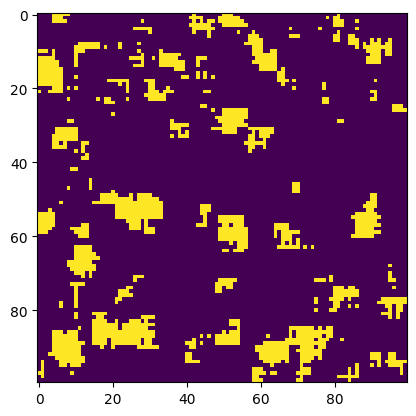

In [7]:
import pandas as pd

from scipy import io


from countdata import CountMatrix
from classifier import SVCClassifier, train_from_countmatrix
import numpy as np

import matplotlib.pyplot as plt

def readfile(filename):
    with open(filename) as f:
        return [line.rstrip() for line in f]


def readfile(filename):
    with open(filename) as f:
        return [line.rstrip() for line in f]


        


def main():
    # Load single-cell reference
    mtx = io.mmread('scmatrix.mtx').T  # (2000,796)
    genes = readfile('scgenes.txt')  # (796)
    labels = readfile('sclabels.txt')  # (2000)

    # Create TopACT object
    sc = CountMatrix(mtx, genes=genes)
    sc.add_metadata("celltype", labels)

    # Train local classifier
    clf = SVCClassifier()
    # clf = KNNClassifier()
    # clf = PCASVCClassifier()
    # clf = SVD_SVCClassifier()
    train_from_countmatrix(clf, sc, "celltype")  # SVM train using sc

    # Load spatial data
    df = pd.read_csv('spatial.csv')

    # Create CountGrid object from coord table
    sd = CountGrid.from_coord_table(df, genes=genes, count_col="counts", gene_col="gene")

    # Classify
    sd.classify_parallel(clf, min_scale=3, max_scale=9, num_proc=1, outfile='outfile.npy')

    confidence_mtx = np.load('outfile.npy')

    annotations = extract_image(confidence_mtx, 0.5)

    np.savetxt("demo-output.txt", annotations, fmt='%1.f')

    plt.imshow(annotations, interpolation='None')
    plt.savefig('demo-output.png')

import multiprocessing as mp

if __name__ == '__main__':
    #mp.set_start_method('fork')
    main()


In [8]:
import importlib
import classifier

# classifier 모듈 재로드
importlib.reload(classifier)

# 이제 임포트 시도
from classifier import SVCClassifier, train_from_countmatrix, KNNClassifier


In [9]:
import os
import sys

# topact 경로를 PYTHONPATH에 추가
topact_path = "/Users/hongseohyeong/Desktop/TopACT_copy/topact"
if topact_path not in sys.path:
    sys.path.append(topact_path)

# 환경변수에 경로 추가 (필요하면)
os.environ['PYTHONPATH'] = topact_path